In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.path.abspath('..'))

In [18]:
import numpy as np 
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
plt.style.use('../plotting/style_sheet.mplstyle')
from toy_rnn.dataset import Dataset
from plotting import plotting_utils
import sklearn
from toy_rnn.dataset import Dataset
from toy_rnn.rnn import MultiSetRNN
from synthetic_data.gaussian_process import GPSpikeGenerator

In [19]:
# Configuration
LATENT_DIM = 5
LATENT_TIMESCALE = 2.0
DT = 0.05
MEDIAN_FIRING_RATE = 40.0
NUM_NEURONS = 100

In [20]:
# Dataset, responsible for generating "synthetic" data 
data_generator = GPSpikeGenerator(
    latent_dim=LATENT_DIM,
    kernel_type="rbf",
    kernel_params={'tau' : LATENT_TIMESCALE},
    dt=DT,
    median_firing_rate=MEDIAN_FIRING_RATE,
    num_neurons=NUM_NEURONS,
)

In [21]:
trial = data_generator.sample(total_time=100.0)

time, latents, firing_rates, spike_counts, spike_times, spike_unit_ids = trial['time'], trial['latents'], trial['firing_rates'], trial['spike_counts'], trial['spike_times'], trial['spike_unit_ids']

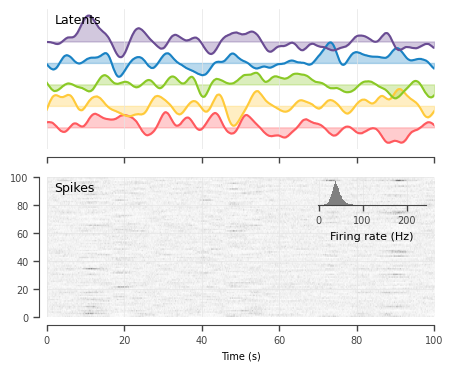

In [22]:
from matplotlib.gridspec import GridSpec

data_fig = plt.figure(figsize=(5, 4)) # Increased figure width for histograms
gs = GridSpec(
    nrows=2, 
    ncols=1,
    figure=data_fig,
    height_ratios=[1, 1],

)

ax_latents = data_fig.add_subplot(gs[0, 0])
ax_spikes = data_fig.add_subplot(gs[1, 0], sharex=ax_latents)

def plot_latents(ax, time, latents):
    # Plot latents
    for l in range(latents.shape[1]):
        line = ax.plot(time, 3*l + latents[:, l])
        ax.fill_between(time, 3*l + latents[:, l], 3*l, alpha=0.3, color=line[0].get_color())
    ax.text(0.02, 0.9, "Latents", transform=ax.transAxes)
    ax.set_prop_cycle(None)  # reset color cycle
    ax.tick_params(axis='x', labelbottom=False) # Remove X labels from top plot
    ax.yaxis.set_visible(False) # Remove Y axis from latent plot
    ax.spines['left'].set_visible(False)

plot_latents(ax_latents, time, latents)

def plot_spikes(ax, time, spike_counts, firing_rates):
    # Plot spikes as an image
    im = ax.imshow((spike_counts/DT).T, aspect='auto', cmap='Greys', origin='lower', extent=[time[0], time[-1], 0, spike_counts.shape[1]])
    ax.text(0.02, 0.9, "Spikes", transform=ax.transAxes)
    ax.set_xlabel("Time (s)")

    # Plot spike count histogram
    ax_hist = ax.inset_axes([0.7, 0.8, 0.28, 0.18])
    ax_hist.hist(firing_rates.flatten(), bins=200, color='gray')
    ax_hist.tick_params(axis='y', labelleft=False) # Remove Y labels
    ax_hist.spines['left'].set_visible(False)
    ax_hist.yaxis.set_visible(False)
    ax_hist.set_xlabel("Firing rate (Hz)", fontdict={'size': 8})

plot_spikes(ax_spikes, time, spike_counts, firing_rates)

# Apply the utility function
plotting_utils.outset_axes(ax_latents)
plotting_utils.outset_axes(ax_spikes)

In [23]:
def fit_pcs(data, n_pcs=None, ground_truth=None,):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_pcs)
    data_centered = data - np.mean(data, axis=0, keepdims=True)
    pcs = pca.fit_transform(data_centered)
    if ground_truth is not None:
        from sklearn.linear_model import LinearRegression
        assert pcs.shape == ground_truth.shape, "PCS and ground truth must have the same shape for alignment."
        reg = LinearRegression(fit_intercept=False).fit(pcs, ground_truth)
        pcs_aligned = reg.predict(pcs)
        return pcs_aligned
    return pcs

Variance explained by first 5 PCs: 0.719


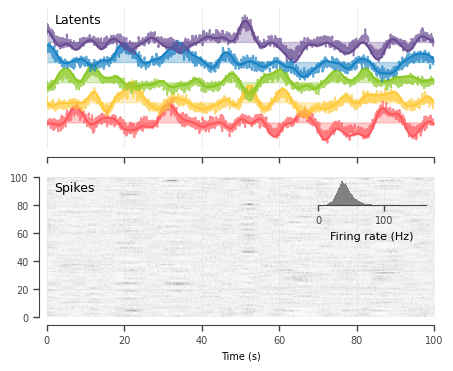

In [8]:
N_PCS = LATENT_DIM

pcs = fit_pcs(spike_counts, n_pcs=N_PCS, ground_truth=latents[:, :N_PCS])
r_sq = sklearn.metrics.r2_score(latents[:, :N_PCS], pcs)
print(f'Variance explained by first {N_PCS} PCs: {r_sq:.3f}')

#deepcopy the figure from before
from copy import deepcopy
data_fig_pcs = deepcopy(data_fig)
ax_latents = data_fig_pcs.axes[0]
ax_latents.set_prop_cycle(None)
for l in range(N_PCS):
    line = ax_latents.plot(time, 3*l + pcs[:, l], linestyle='--', alpha=0.7)

data_fig_pcs

In [38]:
N_SETS = 10
data_generators = [
    GPSpikeGenerator(
        latent_dim=LATENT_DIM,
        kernel_type="rbf",
        kernel_params={'tau' : np.random.uniform(0.5, 5.0)},
        dt=DT,
        median_firing_rate=MEDIAN_FIRING_RATE,
        num_neurons=NUM_NEURONS,
    )
    for _ in range(N_SETS)
]

In [ ]:
BATCH_SIZE = 16
HIDDEN_SIZE = 64

# If cuda or mac GPU available, use that, else CPU
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
device = torch.device("cpu")
print(f"Using device: {device}")

# 1. Init Data
dataset = Dataset(data_generators=data_generators, trial_length=10.0)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE)

# 2. Init Model
model = MultiSetRNN(
    num_sets=N_SETS,
    input_size=NUM_NEURONS,    # Input is spike counts
    hidden_size=HIDDEN_SIZE,   # Size of LSTM hidden state
    latent_dim=LATENT_DIM      # Output target dimension
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# 3. Training Loop
# Note: Since it's an IterableDataset with 'while True', you need a break condition
max_steps = 1000

for step, batch in enumerate(dataloader):
    if step >= max_steps:
        break
    
    # Move data to device
    batch = {k: v.to(device,dtype=torch.float32) for k, v in batch.items()}
    # Unpack data
    x = batch["spike_counts"]  # (Batch, Time, Neurons)
    y = batch["latents"]       # (Batch, Time, Latents)
    indices = batch["dataset_idx"].long() # (Batch)

    # Forward pass
    # We pass both the data AND the indices so the model knows how to route
    predictions = model(x, indices)
    
    # Loss calculation
    loss = criterion(predictions, y)
    
    # Backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if step % 10 == 0:
        print(f"Step {step}, Loss: {loss.item():.4f}")

Using device: mps
Step 0, Loss: 0.9713
Step 10, Loss: 1.0414
Step 20, Loss: 0.9880
Step 30, Loss: 0.6497
Step 40, Loss: 0.6661
Step 50, Loss: 0.5098
Step 60, Loss: 0.5617
Step 70, Loss: 0.3218
Step 80, Loss: 0.2664
Step 90, Loss: 0.2686
Step 100, Loss: 0.1961
Step 110, Loss: 0.2074


KeyboardInterrupt: 

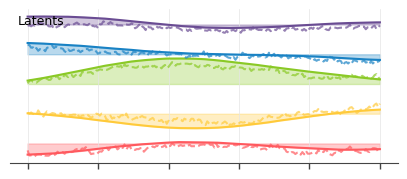

In [59]:
# Evaluate and plot 
model.eval()
with torch.no_grad():
    # Get a batch of data
    batch = next(iter(dataloader))
    batch = {k: v.to(device).float() for k, v in batch.items()}
    x = batch["spike_counts"]
    y = batch["latents"]
    indices = batch["dataset_idx"].long()

    # Get model predictions
    predictions = model(x, indices)

# Convert to numpy for plotting
x_np = x.cpu().numpy()
y_np = y.cpu().numpy()
predictions_np = predictions.cpu().numpy()

# Plot true vs predicted latents for the first trial in the batch
trial_idx = 0
time = np.arange(y_np.shape[1]) * DT
fig, ax = plt.subplots(1,1, figsize=(5,2))

plot_latents(ax, time, y_np[trial_idx, :,])
for l in range(N_PCS):
    line = ax.plot(time, 3*l + predictions_np[trial_idx,:, l], linestyle='--', alpha=0.7)
